# Projet ségmentation client

Useful links : [Subject](https://simplonline.co/briefs/99595e02-a23d-47bc-86e8-738520a13ce5) | [Original datasets (.csv)](https://drive.google.com/drive/folders/15Q-hhe7kmOtQ_c6Cjw9Vx2NXixn7oNud) <br>
This project was realized by : Théo

Technical specifications :
>- Python3

### Table of content
1. [Import des données](#data_import)
2. [Jointure](#joint)
3. [Nettoyage des données](#net)
4. [Création du dataset client](#crea)
5. [Encodage oridnal](#enc)
6. [Exploration visuelle des données](#explo)
7. [Standardisation des données](#stand)
8. [Matrice de corrélation](#corr)
9. [Clustering et elbow chart](#clustering)
10. [Analyse des résultats](#analyse)

----

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%pwd

'/Users/theoprovost/Desktop/SIMPLON/SIMPLON_REPOS/SIMPLON-P/P03'

---------

### <a name="data_import"></a> Import des données

In [21]:
customers = pd.read_csv('./data/customers.csv')
products = pd.read_csv('./data/products.csv')
transactions = pd.read_csv('./data/transactions.csv')

 -----
### Jointure des données <a name="joint"></a>

In [22]:
data_inter = customers.merge(transactions)
dataset = data_inter.merge(products)
dataset

,client_id,sex,birth,id_prod,date,session_id,price,categ
0,c_4410,f,1967,0_1455,2021-03-22 14:29:25.189266,s_9942,8.99,0
1,c_4389,m,1984,0_1455,2021-07-09 11:16:18.579726,s_59967,8.99,0
2,c_5019,f,1977,0_1455,2022-01-15 00:01:53.456196,s_149928,8.99,0
3,c_7049,f,1987,0_1455,2021-03-04 14:01:38.698752,s_1637,8.99,0
4,c_5110,f,1982,0_1455,2021-09-05 11:48:41.065009,s_85364,8.99,0
...,...,...,...,...,...,...,...,...
336908,c_7135,m,1996,2_99,2021-07-11 20:56:49.820935,s_61009,84.99,2
336909,c_5828,f,1998,2_99,2021-11-21 01:53:46.967570,s_122697,84.99,2
336910,c_8260,m,1991,0_833,2021-09-27 23:22:40.394509,s_96558,2.99,0
336911,c_8138,f,1984,0_394,2021-11-09 09:02:38.299240,s_116986,2.14,0


-----
### Nettoyage des données <a name="net"></a>

In [23]:
# recalculer la frquence. groupby session + recence 

In [24]:
# Checks if any data is NA, if True : dataset.isnull().sum() -> count nb of missing values for each feature
if (dataset.isnull().values.any() != True):
    print('No NA data for each fatures of the dataset.')

# Cast str date to date format
type(dataset['date'][0]) # returns str, then :

dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')

# Checks the missing dates
na_dates = dataset[dataset['date'].isna()]
bef = na_dates.count()

# Since all those values contain absurd prices, we drop them
na_dates = na_dates[na_dates['price'] < 0]
af = na_dates.count()

if (bef.all() == af.all()):
    dataset = dataset.drop(dataset[dataset['price'] < 0].index)
    
# Checks if duplication based on the client identifier and the timestamp
is_duplicated = dataset.duplicated(subset=['client_id','date']).all()
print(f'Duplicate values ? {is_duplicated}')

No NA data for each fatures of the dataset.
Duplicate values ? False


----
### Création du dataset client <a name="crea"></a>

In [25]:
# Add age
dataset['age'] = 2022 - dataset['birth']

In [26]:
# Recence
date_format = "%m/%d/%Y"
a = dataset['date']
b = max(dataset['date'])
dataset['recence'] = b-a
dataset['recence'] = dataset['recence'].astype('timedelta64[D]')

dataset_client = (dataset.groupby(['client_id','age','sex'], as_index=False)
                  .agg(
                      montant = ('price', np.sum), 
                      frequence = ('price', 'count'),
                      panier_moyen = ('price', 'mean'),
                      recence = ('recence', 'min')
                  ))


data_categ = pd.pivot_table(dataset, values='price', index='client_id', columns=['categ'], aggfunc=np.sum, fill_value=0)
data_categ = data_categ.reset_index()

dataset_client = pd.merge(dataset_client, data_categ, on='client_id')

# Tranche age
bins = [17, 24, 40, 50, 60, 93]
age_labels = ['Jeune adulte', 'Adulte', 'Adulte+', 'Sénior', 'Sénior+']
dataset_client['tranche_age'] = pd.cut(x=dataset_client['age'], bins=bins, labels=age_labels)

dataset_client = dataset_client.drop('client_id', axis=1)

------
### Encodage ordinal <a name="enc"></a>

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
encoder = LabelEncoder()

dataset_client['sex'] = encoder.fit_transform(dataset_client['sex']) 
dataset_client['tranche_age'] = encoder.fit_transform(dataset_client['tranche_age'])

------------
### Exploration et visualisation des donnés <a name="explo"></a>

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

dataset = dataset_client

In [30]:
dataset.describe()

,age,sex,montant,frequence,panier_moyen,recence,0,1,2,tranche_age
count,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000
mean,43.739302,0.479186,674.020671,39.152674,21.803379,31.631395,259.270076,261.323769,153.426827,1.713488
std,16.908755,0.499596,2565.848732,156.434080,14.698417,45.119481,1261.928137,846.377588,1382.312608,1.492784
min,18.000000,0.000000,4.150000,1.000000,4.150000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,275.765000,14.000000,13.226929,5.000000,47.727500,95.850000,0.000000,0.000000
50%,43.000000,0.000000,501.310000,25.000000,15.711256,15.000000,132.520000,184.405000,0.000000,1.000000
75%,56.000000,1.000000,870.650000,47.000000,21.832368,39.000000,301.610000,340.370000,115.142500,3.000000
max,93.000000,1.000000,162007.340000,12855.000000,181.990000,359.000000,109657.030000,52309.000000,125206.730000,4.000000


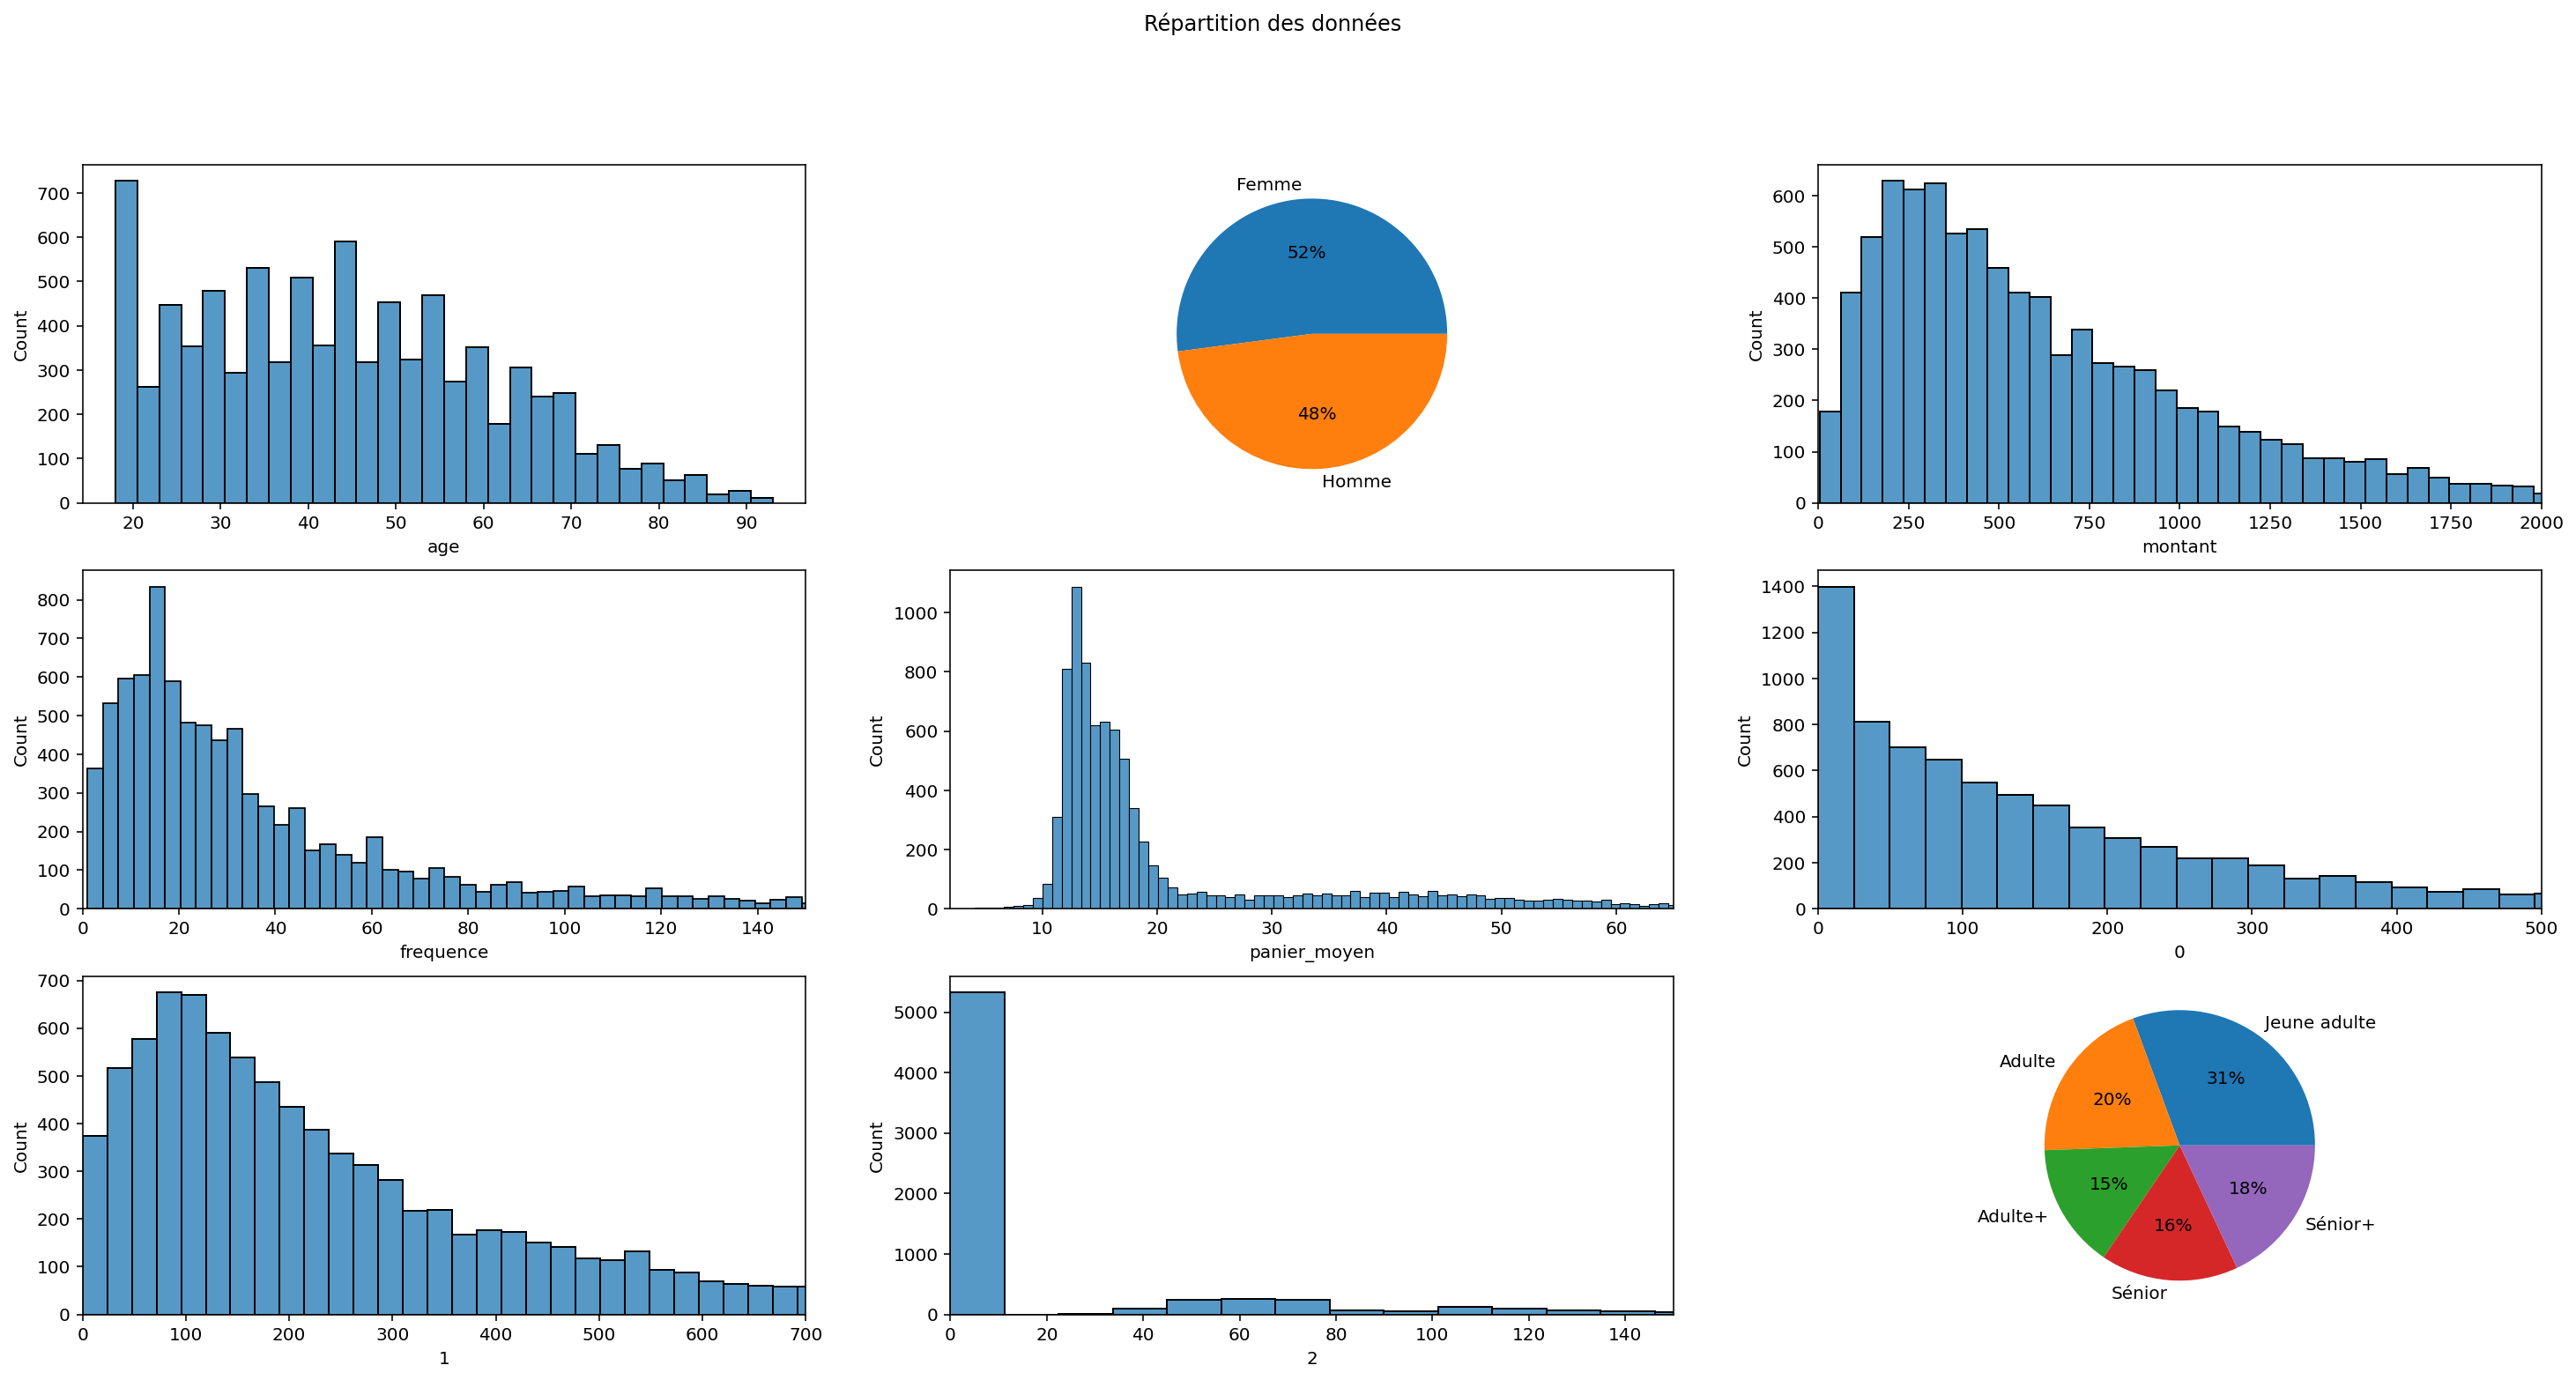

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(25, 12))
fig.suptitle('Répartition des données')

# Âge
sns.histplot(ax=axes[0][0], x=dataset['age'])

# Sex
df_sex = dataset.groupby('sex').size().reset_index(name='counts')
axes[0][1].pie(df_sex['counts'], labels=['Femme', 'Homme'], autopct='%1.0f%%')

# Montant
axes[0][2].set(xlim=(0, 2000))
sns.histplot(ax=axes[0][2], data=dataset['montant'])

# Fréquence
axes[1][0].set(xlim=(0, 150))
sns.histplot(ax=axes[1][0], x=dataset['frequence'])

# Panier moyen
axes[1][1].set(xlim=(2, 65))
sns.histplot(ax=axes[1][1], x=dataset['panier_moyen'])

# MC0
axes[1][2].set(xlim=(0, 500))
sns.histplot(ax=axes[1][2], x=dataset[0])

# MC1
axes[2][0].set(xlim=(0, 700))
sns.histplot(ax=axes[2][0], x=dataset[1])

# MC2
axes[2][1].set(xlim=(0, 150))
sns.histplot(ax=axes[2][1], x=dataset[2])

# Tranche d'âge
df_ta = dataset.groupby('tranche_age').size().reset_index(name='counts')
axes[2][2].pie(x=df_ta['counts'], labels=age_labels, autopct='%1.0f%%')

plt.show()

------
### Standardisation des données <a name="stand"></a>

In [32]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaled_data = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

In [33]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

-----
### Visualisation de la matrice de corrélation <a name="corr"></a>

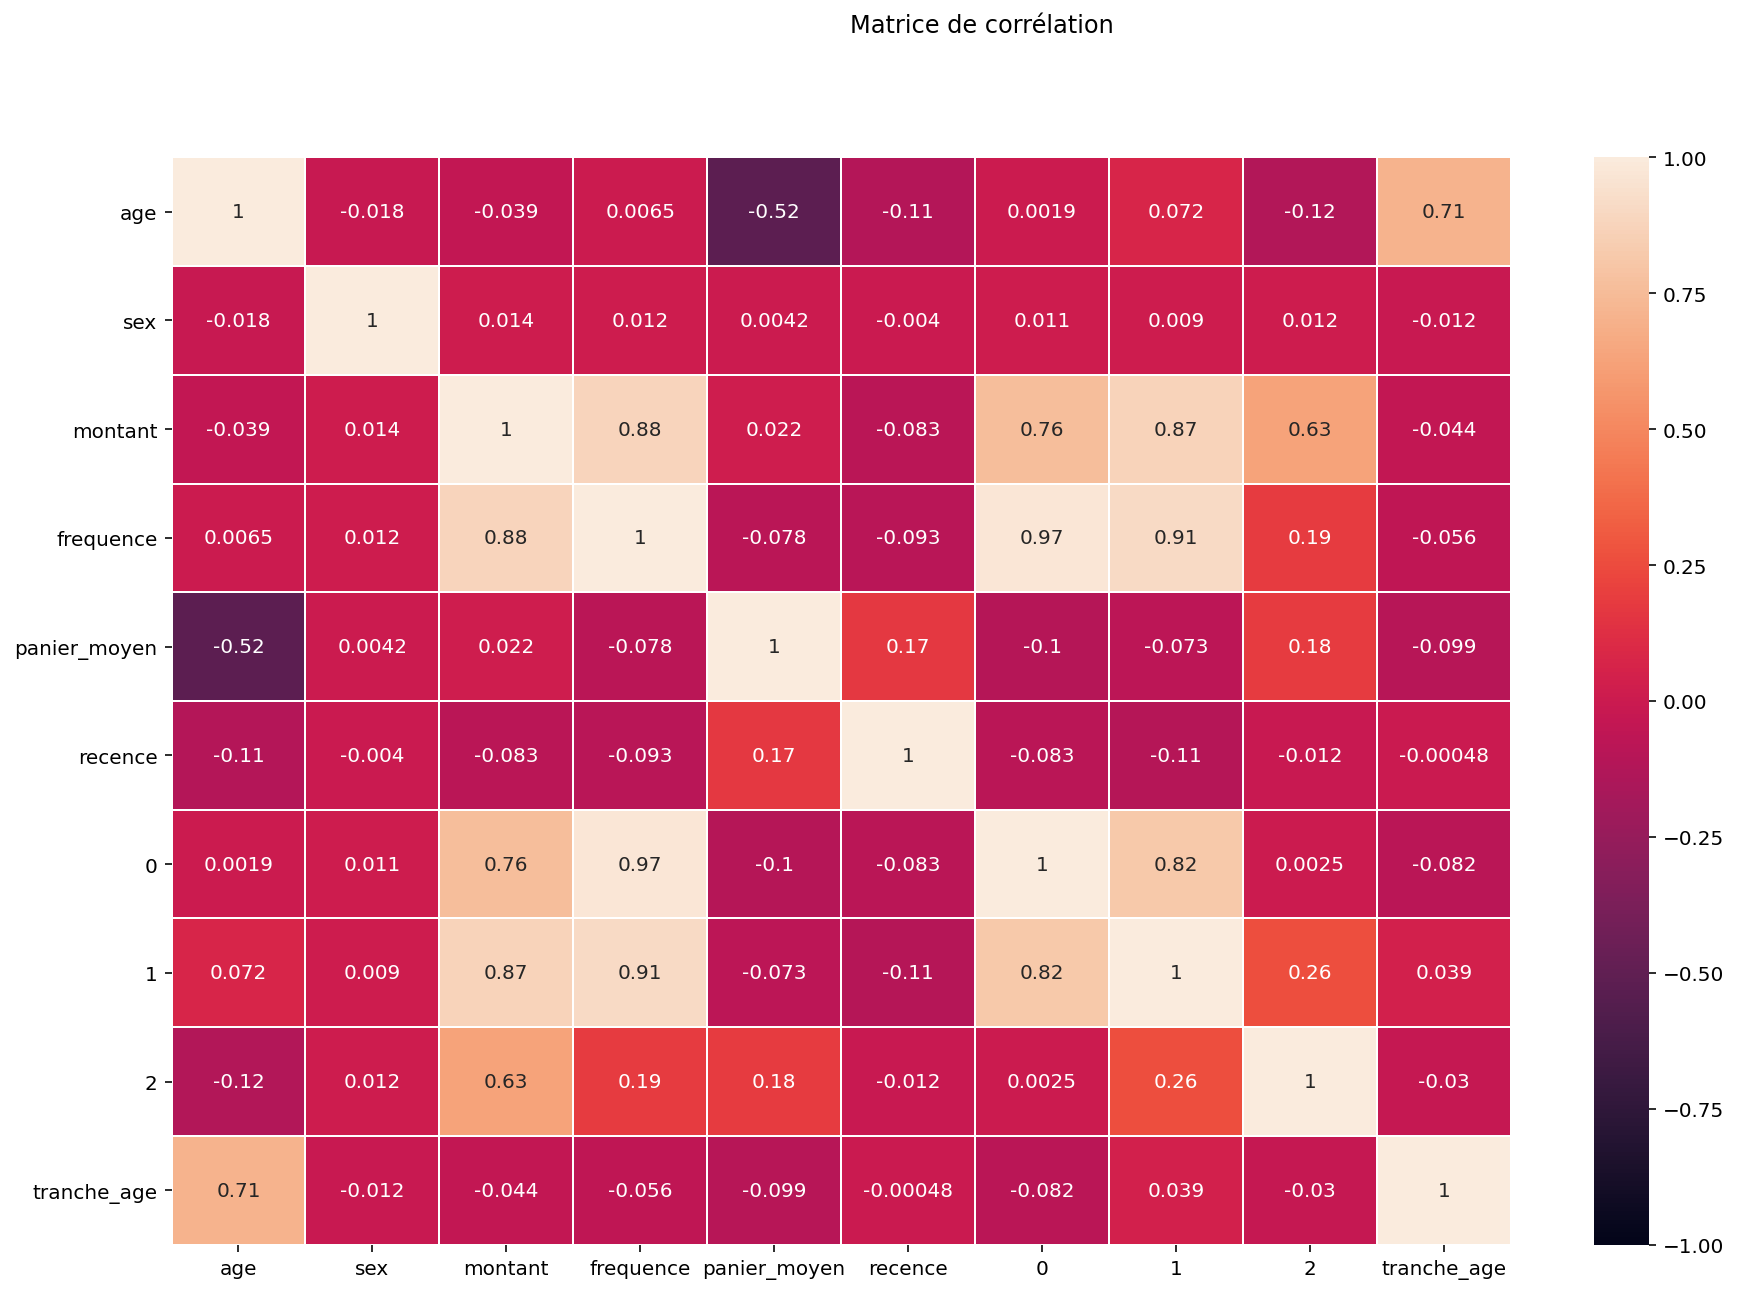

In [34]:
scaled_dataset_corr = scaled_data.corr()

plt.figure(figsize=(15, 10))
plt.suptitle('Matrice de corrélation')
sns.heatmap(scaled_dataset_corr, annot=True, linewidths=.5, vmin=-1, vmax=1)

plt.show()

In [35]:
corr_df = scaled_dataset_corr.unstack().reset_index() 
corr_df

# rename columns
corr_df.columns = ['feature_1','feature_2', 'correlation'] 

# sort by correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) 

# Remove self correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] 

print(corr_df[corr_df['correlation'] > 0.7], corr_df[corr_df['correlation'] < -0.7])

      feature_1    feature_2  correlation
63            0    frequence     0.973646
36    frequence            0     0.973646
73            1    frequence     0.913064
37    frequence            1     0.913064
23      montant    frequence     0.879970
32    frequence      montant     0.879970
72            1      montant     0.872090
27      montant            1     0.872090
67            0            1     0.818031
76            1            0     0.818031
26      montant            0     0.763028
62            0      montant     0.763028
9           age  tranche_age     0.709057
90  tranche_age          age     0.709057 Empty DataFrame
Columns: [feature_1, feature_2, correlation]
Index: []


----
### Clustering <a name="clustering"></a>

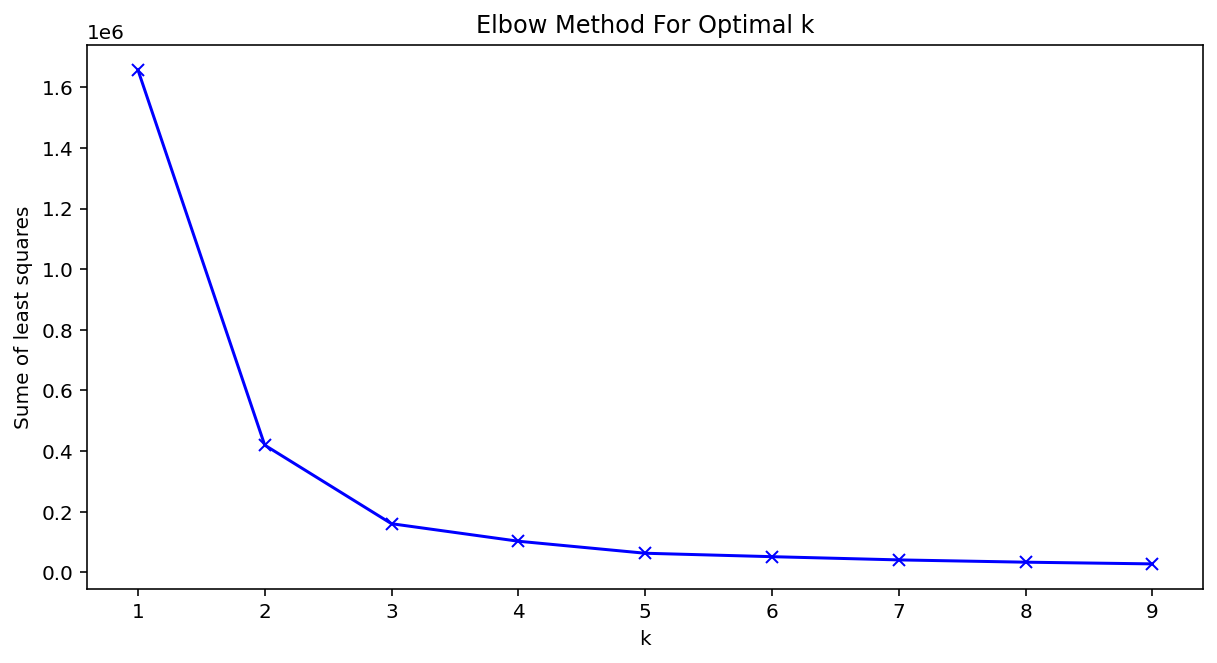

In [36]:
from sklearn.cluster import KMeans

X = scaled_data.drop(labels=['frequence', 'tranche_age', 1], axis=1) 

sum_least_squares = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_least_squares.append(km.inertia_)
 
plt.figure(figsize=(10, 5))
plt.plot(K, sum_least_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sume of least squares')
plt.title('Elbow Method For Optimal k')

plt.show()

In [37]:
from sklearn.metrics import silhouette_score

model = KMeans(n_clusters=3)
model.fit(X)
y_predict = model.predict(X)

score = silhouette_score(X, model.labels_, metric='euclidean')
print(f'Silhouette Score: {score}')

dataset_client["cluster"] = model.labels_
dataset_client.groupby('cluster').agg({
    'recence': ['mean', 'max', 'min'],
    'frequence':['mean', 'max', 'min'],
    'montant':['mean', 'count', 'max', 'min'],
    'age': ['mean', 'max', 'min'],
    0: ['mean', 'max', 'min'],
    2: ['mean', 'max', 'min'],
}).round(2)

Silhouette Score: 0.9913514636511708


recence             frequence                  montant        \
           mean    max  min      mean    max    min       mean count   
cluster                                                                
0         31.64  359.0  0.0     37.37   4471      1     638.56  8598   
1          0.00    0.0  0.0   2562.00   2562   2562  144257.21     1   
2          0.00    0.0  0.0  12855.00  12855  12855  162007.34     1   

                                 age                  0                        \
               max        min   mean max min       mean        max        min   
cluster                                                                         
0         73197.34       4.15  43.74  93  18     246.57   28218.49       0.00   
1        144257.21  144257.21  23.00  23  23      45.77      45.77      45.77   
2        162007.34  162007.34  42.00  42  42  109657.03  109657.03  109657.03   

                 2                        
              mean        max        min  
cluster                                   
0           138.90   10260.00       0.00  
1        125206.73  125206.73  125206.73  
2            41.31      41.31      41.31

-----
### Analyse des résultats <a name="analyse"></a>

Malgré un silhouette score > 0.99, l'interprétation des résultats dans une optique de catégorisation client semble rendue difficile par la présence d'outliers représentées dans les clusters #1 et #2.

Ces données éloignées témoignent soit,
- d'erreurs intrinsèques aux données d'origine
- ou bien la présence d'une typologie de client très particulière et peu fréquente, caractérisée par un montant total d'achat très élevé par rapport aux autres clients. 

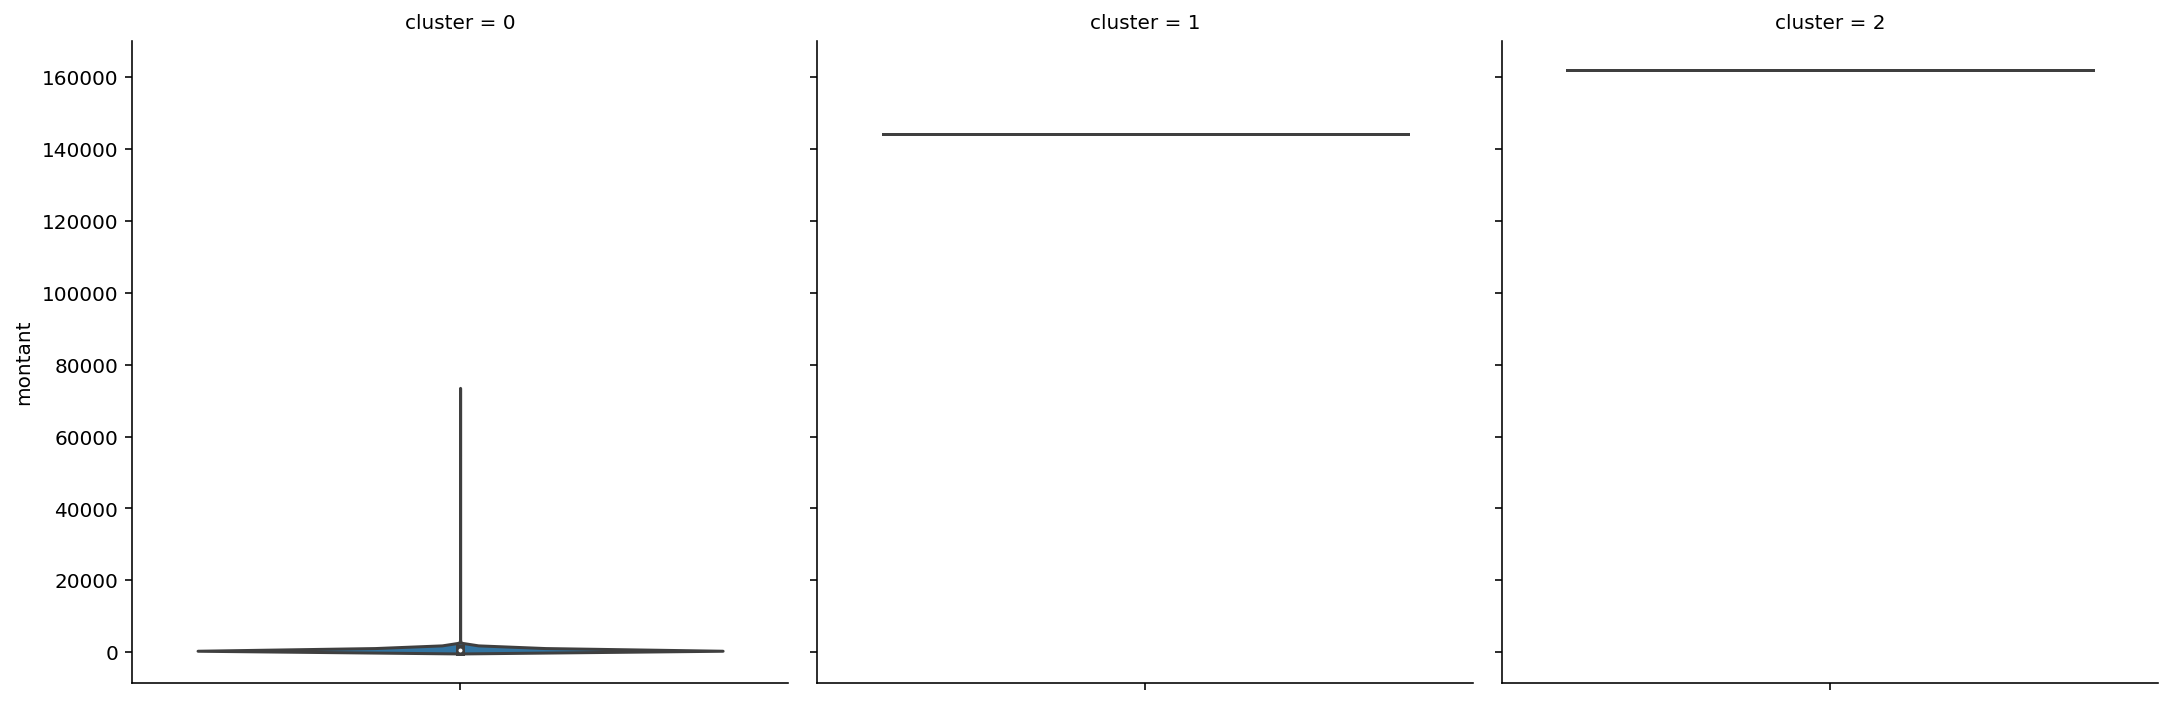

In [41]:
sns.catplot(y='montant', data=dataset_client, col='cluster', kind='violin')
plt.show()